# Implement a fully-connected neural network from scratch

## Requirements:

1. Python 3
2. NumPy
3. Data: download [cifar-10-python.tar.gz](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and extract as **cifar-10-python**

In [1]:
import numpy as np
import pickle
import copy
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class FullyConnectedNetwork(object):
    """
    Abstraction of a Fully Connected Network.
    Stores parameters, activations, cached values. 
    You can add more functions in this class, and also modify inputs and outputs of each function
    
    """
    def __init__(self, layer_dim, lambd=0, batchnorm_moment=0, dropout=0, he_init=False, 
                 optimizer='sgd', adam_setting = {}):
        """
        Parameters:
        - layer_dim: list containing layer dimensions. 
        - lambd: weight for L2 regularization
        - dropout: ratio of dropout; use when dropout != 0
        - dropout_seed: rand seed for dropout (for reproducibility)
        - batchnorm_moment: momentum for running average in batch normalization;
                            - use batch normalization when batchnorm_moment != 0
        - gamma, beta: scale and offset for batch normalization
        - batch_mean, batch_var: running average and variance for batch normalization
        - he_init: use He initialization when he_init is True
        - optimizer: optimize with 'sgd' or 'adam'
        - adam_setting: beta1 and beta2 for adam
        - W_moment, b_moment, gamma_moment, beta_moment: first and second momentum for adam
        - mean: mean of X for preprocessing
        - W, b: for affine transformation
        
        Code:
        Initialize parameters for each layer
        """
        self.layer_dim = layer_dim
        self.lambd = lambd
        self.dropout = dropout
        self.dropout_seed = 0
         
        self.batchnorm_moment = batchnorm_moment
        self.gamma = {}
        self.beta = {}
        self.batch_mean = {}
        self.batch_var = {}   
        
        self.he_init = he_init
        
        self.optimizer = optimizer
        self.adam_setting = adam_setting
        self.W_moment = {}
        self.b_moment = {}
        self.gamma_moment = {}
        self.beta_moment = {}
                
        self.mean = 0
        self.W = {}
        self.b = {}
        
        assert len(self.layer_dim) > 2, "layer_dimensions should be a list longer than 2!"
        assert layer_dim[0] == 3072, "layer_dimensions should start with 3072!"
        assert layer_dim[-1] == 10, "layer_dimensions should end with 10!"
        
        ################################################
        # initialize weights
        ################################################
        
        # initialize W, b for affine transformation; 
        # initialize gamma, beta for batch normalization
        np.random.seed(0)
        initial_scale   = 0.01
        for i_layer in range(len(self.layer_dim)-1):
            if self.he_init:
                initial_scale = 1. / np.sqrt(self.layer_dim[i_layer]/2)
            self.W[i_layer] = np.random.randn(self.layer_dim[i_layer], self.layer_dim[i_layer+1])
            self.W[i_layer] *= initial_scale
            self.b[i_layer] = np.zeros([self.layer_dim[i_layer+1], 1])
            if i_layer < len(self.layer_dim)-2:
                self.gamma[i_layer] = np.ones([self.layer_dim[i_layer+1],1])
                self.beta[i_layer] = np.zeros([self.layer_dim[i_layer+1],1])
                self.batch_mean[i_layer] = np.zeros([self.layer_dim[i_layer+1],1])
                self.batch_var[i_layer] = np.zeros([self.layer_dim[i_layer+1],1])
        
        # initialize momentums for adam
        for i_layer in range(len(self.layer_dim)-1):
            self.W_moment[i_layer] = [np.zeros(self.W[i_layer].shape) for x in range(2)]
            self.b_moment[i_layer] = [np.zeros(self.b[i_layer].shape) for x in range(2)]
            if i_layer < len(self.layer_dim)-2:
                self.gamma_moment[i_layer] = [np.zeros(self.gamma[i_layer].shape) for x in range(2)]
                self.beta_moment[i_layer] = [np.zeros(self.beta[i_layer].shape) for x in range(2)]
        
        ################################################
        # initialize the best model (for testing)
        ################################################
        
        self.best = [{},{},{},{},{},{},0]
        for i_layer in range(len(self.layer_dim)-1):
            self.best[0][i_layer] = self.W[i_layer].copy()
            self.best[1][i_layer] = self.b[i_layer].copy()
            if i_layer < len(self.layer_dim)-2:
                self.best[2][i_layer] = self.gamma[i_layer].copy()
                self.best[3][i_layer] = self.beta[i_layer].copy()
                self.best[4][i_layer] = self.batch_mean[i_layer].copy()
                self.best[5][i_layer] = self.batch_var[i_layer].copy()
        
    def feedforward(self, X, test_flag = False):
        """
        Expected Functionality: 
        Returns output of the neural network for input X. 
        Also returns cache, which contains outputs of intermediate layers 
        which would be useful during backprop.
        """
        cache = []
        A = X
        
        # previous layers: affine - bn - relu - dropout
        for i_layer in range(len(self.layer_dim)-2):
            A, cache_tmp = self.affineForward(A, self.W[i_layer], self.b[i_layer])
            cache.append(cache_tmp)
            if self.batchnorm_moment != 0:
                A, cache_tmp = self.batchnorm_forward(A, i_layer, test_flag)
                cache.append(cache_tmp)
            
            A, cache_tmp = self.relu_forward(A)
            cache.append(cache_tmp)
            
            if self.dropout != 0:
                A, cache_tmp = self.dropout_forward(A, test_flag)
                cache.append(cache_tmp)
        
        # last layer: affine only
        At, cache_tmp = self.affineForward(A, self.W[i_layer+1], self.b[i_layer+1])
        cache.append(cache_tmp)
        
        return At, cache
            
    def loss_function(self, At, Y):
        """
        At is the output of the last layer, returned by feedforward.
        Y contains true labels for this batch.
        this function takes softmax the last layer's output and calculates loss.
        the gradient of loss with respect to the activations of the last layer 
        are also returned by this function.
        
        return:
        - loss: categorical cross entropy + regularization
        - acc: classification accuracy
        - Y_pred: predicted class
        - dAt: gradient of the loss with respect to the activations of the last layer
        """
        
        def softmax(A):
            E = np.exp(A - np.max(A, axis = 0, keepdims = True))
            E = E / np.sum(E, axis = 0, keepdims = True)
            return E
        
        # softmax + categorical cross entropy loss
        E = softmax(At)        
        log_loss = - np.sum(np.log(E[Y,range(E.shape[1])]+1e-8)) / Y.shape[1]
        
        # L2 regularization
        regulation_loss = 0
        for i_layer in range(len(self.layer_dim)-1):
            regulation_loss += 0.5 * self.lambd * np.sum(self.W[i_layer]**2)
        
        loss = log_loss + regulation_loss
        Y_pred = np.argmax(E, axis = 0)
        Y_pred = Y_pred.reshape([1, Y_pred.shape[0]])
        acc = np.mean(Y_pred == Y)
        
        E[Y, range(E.shape[1])] -= 1        
        dAt = E / Y.shape[1]
        
        return loss, acc, Y_pred, dAt
    
    def backprop(self, loss, cache, dAt):
        """
        Expected Functionality: 
        returns gradients for all parameters in the network.
        dAt is the gradient of loss with respect to the output of 
        final layer of the network.
        """ 
        # last layer: affine only
        A, W, b = cache.pop()
        dA, dW, db = self.affineBackward(dAt, (A, W, b))
        dW += self.lambd * W
        
        gradients = {}
        dWs = [0] * (len(self.layer_dim)-1)
        dbs = [0] * (len(self.layer_dim)-1)
        dgammas = [0] * (len(self.layer_dim)-2)
        dbetas = [0] * (len(self.layer_dim)-2)
        
        dWs[len(self.layer_dim) - 2] = dW
        dbs[len(self.layer_dim) - 2] = db
        
        # previous layers: dropout - relu - bn - affine (+regularization) 
        for i_layer in range(len(self.layer_dim)-2):
            
            if self.dropout != 0:
                dA = self.dropout_backward(dA, cache.pop())
            dA = self.relu_backward(dA, cache.pop())
            if self.batchnorm_moment != 0:
                Abn, Ares, Avar, gamma = cache.pop()           
                dA, dgamma, dbeta = self.batchnorm_backward(dA, (Abn, Ares, Avar, gamma))
                dgammas[len(self.layer_dim) - 3 - i_layer] = dgamma
                dbetas[len(self.layer_dim) - 3 - i_layer] = dbeta

            A, W, b = cache.pop()
            dA, dW, db = self.affineBackward(dA, (A, W, b))
            dW += self.lambd * W
            
            dWs[len(self.layer_dim) - 3 - i_layer] = dW
            dbs[len(self.layer_dim) - 3 - i_layer] = db
        
        # return gradients for optimization
        gradients['W'] = dWs
        gradients['b'] = dbs
        gradients['gamma'] = dgammas
        gradients['beta'] = dbetas
        
        return gradients
         
    def updateParameters(self, gradients, learning_rate, decay, iter_curr):
        """
        Expected Functionality:
        use gradients returned by backprop to update the parameters.
        """
        
        learning_rate = learning_rate / (1 + decay*iter_curr)
        
        # update W, b for affine transformation
        # update gamma, beta for batch normalization            
        for i_layer in range(len(self.layer_dim)-1):  
            self.W[i_layer], self.W_moment[i_layer] = \
            self.optimization(self.W[i_layer], gradients['W'][i_layer], 
                              self.W_moment[i_layer],learning_rate,iter_curr)
            
            self.b[i_layer], self.b_moment[i_layer] = \
            self.optimization(self.b[i_layer], gradients['b'][i_layer],
                              self.b_moment[i_layer],learning_rate,iter_curr)
            
            if self.batchnorm_moment != 0 and i_layer < len(self.layer_dim)-2:
                self.gamma[i_layer], self.gamma_moment[i_layer] = \
                self.optimization(self.gamma[i_layer], gradients['gamma'][i_layer],
                                  self.gamma_moment[i_layer],learning_rate,iter_curr)
                self.beta[i_layer], self.beta_moment[i_layer] = \
                self.optimization(self.beta[i_layer], gradients['beta'][i_layer], 
                                  self.beta_moment[i_layer],learning_rate,iter_curr)
                
    def optimization(self, x, dx, moment, learning_rate, iter_curr):
        """
        Expected Functionality:
        update parameters using sgd or adam.
        """
            
        if self.optimizer == 'adam':
            first_moment = moment[0].copy()
            second_moment = moment[1].copy()
            beta1 = self.adam_setting['beta1']
            beta2 = self.adam_setting['beta2']
            first_moment = beta1 * first_moment + (1-beta1) * dx
            second_moment = beta2 * second_moment + (1-beta2) * dx * dx
            first_unbias = first_moment / (1-beta1**(iter_curr+1))
            second_unbias = second_moment / (1-beta2**(iter_curr+1))
            x -= learning_rate * first_unbias / (np.sqrt(second_unbias) + 1e-8)
            moment = [first_moment, second_moment]
        else:
            x -= learning_rate * dx
        
        return x, moment
    
    def affineForward(self, A, W, b):
        """
        Expected Functionality:
        Forward pass for the affine layer.
        - A: input matrix, shape (L, S), 
        - L is the number of hidden units in the previous layer 
        - S is the number of samples
        - param W: shape (L, L+1)
        - param b: shape (L+1, 1)
        
        returns: the affine product WA + b, and the cache for the backward pass
        """
        cache = (A, W, b)
        Anew = np.matmul(W.T, A) + b
                
        return Anew, cache
    
    def affineBackward(self, dA_prev, cache):
        """
        Expected Functionality:
        Backward pass for the affine layer.
        - dA_prev: gradient from the next layer.
        - cache: cache returned in affineForward
        
        returns dA: gradient on the input to this layer
                dW: gradient on the weights
                db: gradient on the bias
        """
        A, W, b = cache
        dA = np.matmul(W, dA_prev)
        dW = np.matmul(A, dA_prev.T)
        db = np.sum(dA_prev, axis = 1, keepdims = True)

        return dA, dW, db
        
    def relu_forward(self, A):
        """
        Expected Functionality:
        Forward pass of relu activation
        
        returns (A, cache)
        """
        cache = A.copy()
        A[A < 0] = 0
        return A, cache
        
    def relu_backward(self, dA_prev, cache):
        """
        Expected Functionality:
        backward pass for relu activation
        """
        A = cache
        dA = dA_prev.copy()
        dA[A <= 0] = 0
        return dA        
    
    def batchnorm_forward(self, A, i_layer, test_flag = False):
        """
        Expected Functionality:
        Forward pass of batch normalization
        
        returns (Anew, cache)
        """
                
        gamma = self.gamma[i_layer].copy()
        beta = self.beta[i_layer].copy()
        batch_mean = self.batch_mean[i_layer].copy()
        batch_var = self.batch_var[i_layer].copy()
        momentum = self.batchnorm_moment
        
        # compute running average, variance in training
        # apply trained running average, variance when testing        
        if test_flag:
            Amean = batch_mean
            Avar = batch_var
            Ares = A - Amean
            Abn = Ares / np.sqrt(Avar + 1e-8)
            Anew = gamma * Abn + beta            
        else: 
            Amean = np.mean(A, axis = 1, keepdims = True)
            Ares = A - Amean
            Avar = np.mean(Ares ** 2, axis = 1, keepdims = True)
            Abn = Ares / np.sqrt(Avar + 1e-8)
            Anew = gamma * Abn + beta
                        
            if np.sum(batch_var) == 0:
                batch_mean = Amean
                batch_var = Avar
            else:
                batch_mean = batch_mean * momentum + Amean * (1 - momentum)
                batch_var = batch_var * momentum + Avar * (1 - momentum)
            self.batch_mean[i_layer] = batch_mean.copy()
            self.batch_var[i_layer] = batch_var.copy()
                
        cache = (Abn, Ares, Avar, gamma)

        return Anew, cache

    def batchnorm_backward(self, dA_prev, cache):
        """
        Expected Functionality:
        backward pass of batch normalization
        
        Parameter to be optimized: A, gamma, beta
        """

        Abn, Ares, Avar, gamma = cache
        Astd = np.sqrt(Avar + 1e-8)
        dAbn = dA_prev * gamma
        dAres = dAbn / Astd
        dAvar = np.sum( - 0.5 * (dAbn * Ares) / (Avar * Astd), axis=1, keepdims = True)
        dAres += dAvar * Ares * 2. / Abn.shape[1]  
        dA = dAres - np.mean(dAres, axis = 1, keepdims = True)
        dgamma = np.sum(dA_prev * Abn, axis = 1, keepdims = True)
        dbeta = np.sum(dA_prev, axis = 1, keepdims = True)        
        return dA, dgamma, dbeta

    def dropout_forward(self, A, test_flag = False):
        """
        Expected Functionality:
        Forward pass of dropout
        """

        ratio = self.dropout
        np.random.seed(self.dropout_seed)
        kept = (np.random.rand(* A.shape) >= ratio) / (1 - ratio)
        cache = kept
        
        if test_flag:
            Anew = A.copy()
        else:
            Anew = A * kept
        
        self.dropout_seed += 1
        return Anew, cache

    def dropout_backward(self, dA_prev, cache):
        """
        Expected Functionality:
        Backward pass of dropout
        """
        
        kept = cache.copy()
        dA = dA_prev * kept
    
        return dA 
    
    def get_batch(self, X, Y, batch_size):
        """
        Expected Functionality: 
        given the full training data (X, Y)
        return batches for each iteration of forward and backward prop.
        """
        batch_count = 0        
        while True:
            if (batch_count + 1) * batch_size >= Y.shape[1]:
                batch_count = 0

            start = batch_count * batch_size
            end = start + batch_size
            batch_count += 1
            yield X[:,start:end], Y[:,start:end]
            
    def train(self, X, Y, max_iters=5000, batch_size=100, validate_every=200,
              learning_rate=0.01, decay=0):
        """
        X: (3072 dimensions, 50000 examples) (Cifar train data)
        Y: (1 dimension, 50000 examples)
        lambd: the hyperparameter corresponding to L2 regularization
        
        Divide X, Y into train(80%) and val(20%)
        During training do evaluation on val set after every validate_every iterations 
        In the end use the parameters corresponding to the best val set to test. 
        Print the accuracy that is calculated on the train vs. val set during training. 
        Print the final test accuracy. 
        Ensure that these printed values can be seen in the .ipynb file you submit.
        
        Expected Functionality: 
        This function will call functions feedforward, backprop and update_params. 
        Also, evaluate on the validation set for tuning the hyperparameters.
        """
        
        ####################################################################
        # Divide X, Y into train(80%) and val(20%) via stratified sampling
        ####################################################################
        
        def split_train_val(X, Y):
            
            np.random.seed(0)
            id_train = []
            id_val   = []
            for n_class in np.unique(Y):
                classid = np.random.permutation(np.argwhere(Y == n_class))
                classid = classid[:,1].tolist()
                id_train += classid[:int(len(classid)*0.8)]
                id_val += classid[int(len(classid)*0.8):]
            return X[:,id_train], Y[:,id_train], X[:,id_val], Y[:,id_val]
        
        X_train, Y_train, X_val, Y_val = split_train_val(X, Y)
        
        # Random permutation on training
        np.random.seed(0)
        randord = np.random.permutation(X_train.shape[1]).tolist()
        X_train = X_train[:,randord]
        Y_train = Y_train[:,randord]
                
        self.mean = np.mean(X_train)
        
        # Batch generator
        data_generator = self.get_batch(X_train, Y_train, batch_size)
        
        # Record history of loss and accuracy 
        history_loss_train = []
        history_loss_val = []
        history_acc_train = []
        history_acc_val = []
        history_loss_best = 10**6
        history_tolerance = 0
        
        for n_epoch in range(max_iters):
            
            # Input X: type float32 and zero mean
            X_curr, Y_curr = next(data_generator)
            X_curr = np.float32(X_curr)
            X_curr -= self.mean 
            
            At, cache = self.feedforward(X_curr)
            loss_train, acc_train, _, dAt = self.loss_function(At, Y_curr)
            gradients = self.backprop(loss_train, cache, dAt)
            self.updateParameters(gradients, learning_rate, decay, n_epoch/validate_every)
            
            if n_epoch % validate_every == 0:
                
                loss_train, acc_train, _ = self.evaluate(X_train, Y_train)
                loss_val, acc_val, _ = self.evaluate(X_val, Y_val)
                print("Epoch: {} train loss = {:.3f} accuracy = {:.3f} | validation loss = {:.3f} accuracy = {:.3f}".
                      format(int(n_epoch/validate_every), loss_train, acc_train, loss_val, acc_val))  
                
                # Best model: lowest loss_val
                # history_tolerance handles noise
                if loss_val < history_loss_best and history_tolerance <= 5:
                    for i_layer in range(len(self.layer_dim)-1):
                        self.best[0][i_layer] = self.W[i_layer].copy()
                        self.best[1][i_layer] = self.b[i_layer].copy()
                        if i_layer < len(self.layer_dim)-2:
                            self.best[2][i_layer] = self.gamma[i_layer].copy()
                            self.best[3][i_layer] = self.beta[i_layer].copy()
                            self.best[4][i_layer] = self.batch_mean[i_layer].copy()
                            self.best[5][i_layer] = self.batch_var[i_layer].copy()
                    self.best[6] = int(n_epoch/validate_every)
                    history_loss_best = loss_val
                    history_tolerance = 0
                else:
                    history_tolerance += 1
                    
                history_loss_train.append(loss_train)
                history_loss_val.append(loss_val)
                history_acc_train.append(acc_train)
                history_acc_val.append(acc_val)
        
        return (history_loss_train, history_loss_val, history_acc_train, history_acc_val)
                    
    def evaluate(self, X_test, Y_test, use_best = False):
        '''
        X: X_test (3472 dimensions, 10000 examples)
        Y: Y_test (1 dimension, 10000 examples)
        
        Expected Functionality: 
        print accuracy on test set
        ''' 
        # use_best = True: use best model for test set 
        if use_best:
            self.W = self.best[0].copy()
            self.b = self.best[1].copy()
            self.gamma = self.best[2].copy()
            self.beta = self.best[3].copy()
            self.batch_mean = self.best[4].copy()
            self.batch_var = self.best[5].copy()
            print("Loading model from epoch {}".format(self.best[6]))  
            
        Loss = []
        Acc = []
        Y_pred = np.zeros(Y_test.shape)
                
        num_test = 100
        iter_test = 0
        while iter_test < X_test.shape[1]:
            start = iter_test
            end = min(iter_test+num_test, X_test.shape[1])
            X_curr = np.float32(X_test[:,start:end])
            X_curr -= self.mean
            At, _ = self.feedforward(X_curr, test_flag=True)
            loss, acc, Y_pred[:,start:end], _ = self.loss_function(At, Y_test[:,start:end]) 
            Loss.append(loss)
            Acc.append(acc)
            iter_test = end

        return np.mean(np.array(Loss)), np.mean(np.array(Acc)), Y_pred

In [3]:
class Loader:
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    def load_train_data(self):
        '''
        loads training data: 50,000 examples with 3072 features
        '''
        X_train = None
        Y_train = None
        for i in range(1, 6):
            pickleFile = self.unpickle('cifar-10-batches-py/data_batch_{}'.format(i))
            dataX = pickleFile[b'data']
            dataY = pickleFile[b'labels']
            if type(X_train) is np.ndarray:
                X_train = np.concatenate((X_train, dataX))
                Y_train = np.concatenate((Y_train, dataY))
            else:
                X_train = dataX
                Y_train = dataY

        Y_train = Y_train.reshape(Y_train.shape[0], 1)

        return X_train.T, Y_train.T

    def load_test_data(self):
        '''
        loads testing data: 10,000 examples with 3072 features
        '''
        X_test = None
        Y_test = None
        pickleFile = self.unpickle('cifar-10-batches-py/test_batch')
        dataX = pickleFile[b'data']
        dataY = pickleFile[b'labels']
        if type(X_test) is np.ndarray:
            X_test = np.concatenate((X_test, dataX))
            Y_test = np.concatenate((Y_test, dataY))
        else:
            X_test = np.array(dataX)
            Y_test = np.array(dataY)

        Y_test = Y_test.reshape(Y_test.shape[0], 1)

        return X_test.T, Y_test.T

In [4]:
X_train,Y_train = Loader().load_train_data()
X_test, Y_test = Loader().load_test_data()

print("X_Train: {} -> {} examples, {} features".format(X_train.shape, X_train.shape[1], X_train.shape[0]))
print("Y_Train: {} -> {} examples, {} features".format(Y_train.shape, Y_train.shape[1], Y_train.shape[0]))
print("X_Test: {} -> {} examples, {} features".format(X_test.shape, X_test.shape[1], X_test.shape[0]))
print("Y_Test: {} -> {} examples, {} features".format(Y_test.shape, Y_test.shape[1], Y_test.shape[0]))

X_Train: (3072, 50000) -> 50000 examples, 3072 features
Y_Train: (1, 50000) -> 50000 examples, 1 features
X_Test: (3072, 10000) -> 10000 examples, 3072 features
Y_Test: (1, 10000) -> 10000 examples, 1 features


## Basic Neural Nework

* Parameter Setting: use default basic setting

In [5]:
layer_dimensions = [3072,200,100,10]  
n_train = int(X_train.shape[1] * 8 / 10)
batch_size = 200
validate_every = int(n_train / batch_size)
max_iters = validate_every * 50
learning_rate = 0.001
print("Parameter Setting (Basic Neural Nework):")
print("- layer_dimensions = {}".format(layer_dimensions))
print("- batch_size = {}".format(batch_size))
print("- validate_every = {}".format(validate_every))
print("- max_iters = {}".format(max_iters))
print("- learning_rate = {}".format(learning_rate))

Parameter Setting (Basic Neural Nework):
- layer_dimensions = [3072, 200, 100, 10]
- batch_size = 200
- validate_every = 200
- max_iters = 10000
- learning_rate = 0.001


* While training, print the history of loss and accuracy for training and validation
* One epoch = *validate_every* iterations:
  * Number of samples trained per epoch = number of training samples = batch size * validate_every = 40000

In [6]:
print("Begin training...")
FCN = FullyConnectedNetwork(layer_dimensions, lambd=0)
history = FCN.train(X_train, Y_train, 
                    batch_size=batch_size, 
                    validate_every=validate_every, 
                    max_iters=max_iters, 
                    learning_rate=learning_rate)

Begin training...
Epoch: 0 train loss = 2.317 accuracy = 0.101 | validation loss = 2.314 accuracy = 0.107
Epoch: 1 train loss = 1.884 accuracy = 0.337 | validation loss = 1.882 accuracy = 0.344
Epoch: 2 train loss = 1.756 accuracy = 0.383 | validation loss = 1.761 accuracy = 0.384
Epoch: 3 train loss = 1.679 accuracy = 0.408 | validation loss = 1.690 accuracy = 0.412
Epoch: 4 train loss = 1.623 accuracy = 0.429 | validation loss = 1.642 accuracy = 0.427
Epoch: 5 train loss = 1.581 accuracy = 0.443 | validation loss = 1.607 accuracy = 0.438
Epoch: 6 train loss = 1.545 accuracy = 0.457 | validation loss = 1.579 accuracy = 0.448
Epoch: 7 train loss = 1.513 accuracy = 0.469 | validation loss = 1.558 accuracy = 0.452
Epoch: 8 train loss = 1.482 accuracy = 0.480 | validation loss = 1.537 accuracy = 0.460
Epoch: 9 train loss = 1.454 accuracy = 0.489 | validation loss = 1.519 accuracy = 0.466
Epoch: 10 train loss = 1.427 accuracy = 0.498 | validation loss = 1.502 accuracy = 0.473
Epoch: 11 tra

* Plot loss and accuracy vs. iteration for training and validation

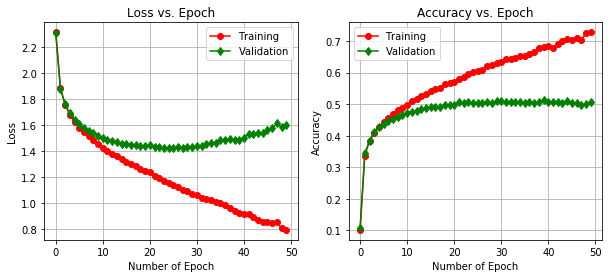

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(range(0,int(max_iters/validate_every)), history[0], 'ro-', label='Training')
plt.plot(range(0,int(max_iters/validate_every)), history[1], 'gd-', label='Validation')
plt.title('Loss vs. Epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(range(0,int(max_iters/validate_every)), history[2], 'ro-', label='Training')
plt.plot(range(0,int(max_iters/validate_every)), history[3], 'gd-', label='Validation')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

* Evaluate on test data
* Use the best model from epoch 24 where: 
  * Validatioin loss = 1.423 and classification accuracy = 0.504
* Classification result on test set: 
  * Test loss = 1.422 and classification accuracy = 0.505

In [8]:
print("Begin testing...")
loss_test, acc_test, Y_pred_test = FCN.evaluate(X_test,Y_test, use_best = True) 
print("Test result: loss = {:.3f} accuracy = {:.3f}".format(loss_test, acc_test))

Begin testing...
Loading model from epoch 24
Test result: loss = 1.422 accuracy = 0.505


## NN with Regularization 

Parameter Setting
* Add L2 regularization to basic setting, and set lambd = 0.1

In [9]:
layer_dimensions = [3072,200,100,10]  
n_train = int(X_train.shape[1] * 8 / 10)
batch_size = 200
validate_every = int(n_train / batch_size)
max_iters = validate_every * 50
learning_rate = 0.002
lambd = 0.1
print("Parameter Setting (Regularization):")
print("- layer_dimensions = {}".format(layer_dimensions))
print("- batch_size = {}".format(batch_size))
print("- validate_every = {}".format(validate_every))
print("- max_iters = {}".format(max_iters))
print("- learning_rate = {}".format(learning_rate))
print("- lambd = {}".format(lambd))

Parameter Setting (Regularization):
- layer_dimensions = [3072, 200, 100, 10]
- batch_size = 200
- validate_every = 200
- max_iters = 10000
- learning_rate = 0.002
- lambd = 0.1


* While training, print the history of loss and accuracy for training and validation

In [10]:
print("Begin training...")
FCN = FullyConnectedNetwork(layer_dimensions, lambd=lambd)
history = FCN.train(X_train, Y_train, 
                    batch_size=batch_size, 
                    validate_every=validate_every, 
                    max_iters=max_iters, 
                    learning_rate=learning_rate)

Begin training...
Epoch: 0 train loss = 5.482 accuracy = 0.106 | validation loss = 5.479 accuracy = 0.112
Epoch: 1 train loss = 4.706 accuracy = 0.381 | validation loss = 4.709 accuracy = 0.387
Epoch: 2 train loss = 4.368 accuracy = 0.423 | validation loss = 4.384 accuracy = 0.422
Epoch: 3 train loss = 4.094 accuracy = 0.447 | validation loss = 4.121 accuracy = 0.442
Epoch: 4 train loss = 3.849 accuracy = 0.468 | validation loss = 3.888 accuracy = 0.455
Epoch: 5 train loss = 3.633 accuracy = 0.487 | validation loss = 3.687 accuracy = 0.467
Epoch: 6 train loss = 3.442 accuracy = 0.501 | validation loss = 3.507 accuracy = 0.473
Epoch: 7 train loss = 3.258 accuracy = 0.518 | validation loss = 3.340 accuracy = 0.486
Epoch: 8 train loss = 3.090 accuracy = 0.531 | validation loss = 3.188 accuracy = 0.491
Epoch: 9 train loss = 2.939 accuracy = 0.540 | validation loss = 3.054 accuracy = 0.494
Epoch: 10 train loss = 2.804 accuracy = 0.549 | validation loss = 2.933 accuracy = 0.498
Epoch: 11 tra

* Plot loss and accuracy vs. iteration for training and validation

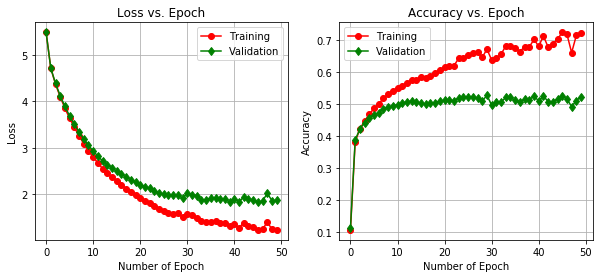

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(range(0,int(max_iters/validate_every)), history[0], 'ro-', label='Training')
plt.plot(range(0,int(max_iters/validate_every)), history[1], 'gd-', label='Validation')
plt.title('Loss vs. Epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(range(0,int(max_iters/validate_every)), history[2], 'ro-', label='Training')
plt.plot(range(0,int(max_iters/validate_every)), history[3], 'gd-', label='Validation')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

* Use the best model from epoch 45 where: 
  * Validatioin loss = 1.832 and classification accuracy = 0.527
* Classification result on test set: 
  * Test loss = 1.836 and classification accuracy = 0.526
* Compared to the basic model, the test accuracy increased by 0.526 - 0.505 = 0.21

In [12]:
print("Begin testing...")
loss_test, acc_test, Y_pred_test = FCN.evaluate(X_test,Y_test, use_best = True) 
print("Test result: loss = {:.3f} accuracy = {:.3f}".format(loss_test, acc_test))

Begin testing...
Loading model from epoch 45
Test result: loss = 1.836 accuracy = 0.526


## Advanced Setting

Parameter Setting
* Added dropout 
* Added batch normalization
* Opitimized with Adam
* Added learning rate decay
* Used He initialization
* Increased the number of layers and number of neurons

In [16]:
layer_dimensions = [3072,400,200,100,10]  
n_train = int(X_train.shape[1] * 8 / 10)
batch_size = 200
validate_every = int(n_train / batch_size)
max_iters = validate_every * 30
learning_rate = 0.01
lambd = 0.01
dropout = 0.5
decay = 0.9
he_init = True
batchnorm_moment = 0.9
optimizer = 'adam'
adam_setting = {}
adam_setting['beta1'] = 0.9
adam_setting['beta2'] = 0.999
print("Parameter Setting (Regularization):")
print("- layer_dimensions = {}".format(layer_dimensions))
print("- batch_size = {}".format(batch_size))
print("- validate_every = {}".format(validate_every))
print("- max_iters = {}".format(max_iters))
print("- learning_rate = {}".format(learning_rate))
print("- lambd = {}".format(lambd))
print("- dropout = {}".format(dropout))
if batchnorm_moment != 0:
    print("- batch normalization momentum = {}".format(batchnorm_moment))
print("- learning rate decay = {}".format(decay))
if he_init:
    print("- use He Initialziation")
print("- optimizer = {}".format(optimizer))
if optimizer == 'adam':
    print("- adam beta1 = {} beta2 = {}".format(adam_setting['beta1'],adam_setting['beta2']))

Parameter Setting (Regularization):
- layer_dimensions = [3072, 400, 200, 100, 10]
- batch_size = 200
- validate_every = 200
- max_iters = 6000
- learning_rate = 0.01
- lambd = 0.01
- dropout = 0.5
- batch normalization momentum = 0.9
- learning rate decay = 0.9
- use He Initialziation
- optimizer = adam
- adam beta1 = 0.9 beta2 = 0.999


* While training, print the history of loss and accuracy for training and validation

In [17]:
print("Begin training...")
FCN = FullyConnectedNetwork(layer_dimensions, lambd = lambd,
                            batchnorm_moment = batchnorm_moment, dropout = dropout, 
                            optimizer = optimizer, adam_setting = adam_setting, he_init = he_init)
history = FCN.train(X_train, Y_train, 
                    batch_size=batch_size, 
                    validate_every=validate_every, 
                    max_iters=max_iters, 
                    learning_rate=learning_rate,
                    decay=decay)

Begin training...
Epoch: 0 train loss = 12.384 accuracy = 0.132 | validation loss = 12.408 accuracy = 0.133
Epoch: 1 train loss = 2.343 accuracy = 0.337 | validation loss = 2.339 accuracy = 0.345
Epoch: 2 train loss = 2.102 accuracy = 0.367 | validation loss = 2.109 accuracy = 0.366
Epoch: 3 train loss = 1.965 accuracy = 0.399 | validation loss = 1.978 accuracy = 0.398
Epoch: 4 train loss = 1.874 accuracy = 0.409 | validation loss = 1.889 accuracy = 0.409
Epoch: 5 train loss = 1.797 accuracy = 0.437 | validation loss = 1.816 accuracy = 0.435
Epoch: 6 train loss = 1.745 accuracy = 0.447 | validation loss = 1.772 accuracy = 0.444
Epoch: 7 train loss = 1.699 accuracy = 0.462 | validation loss = 1.731 accuracy = 0.453
Epoch: 8 train loss = 1.649 accuracy = 0.482 | validation loss = 1.684 accuracy = 0.471
Epoch: 9 train loss = 1.626 accuracy = 0.484 | validation loss = 1.668 accuracy = 0.470
Epoch: 10 train loss = 1.582 accuracy = 0.497 | validation loss = 1.630 accuracy = 0.480
Epoch: 11 t

* Plot loss and accuracy vs. iteration for training and validation

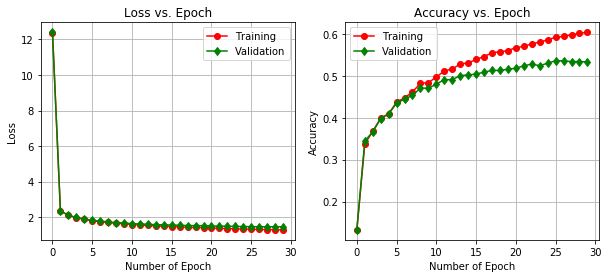

In [18]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(range(0,int(max_iters/validate_every)), history[0], 'ro-', label='Training')
plt.plot(range(0,int(max_iters/validate_every)), history[1], 'gd-', label='Validation')
plt.title('Loss vs. Epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(range(0,int(max_iters/validate_every)), history[2], 'ro-', label='Training')
plt.plot(range(0,int(max_iters/validate_every)), history[3], 'gd-', label='Validation')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

* Evaluate on test data, using the best model

In [19]:
print("Begin testing...")
loss_test, acc_test, Y_pred_test = FCN.evaluate(X_test,Y_test, use_best = True) 
print("Test result: loss = {:.3f} accuracy = {:.3f}".format(loss_test, acc_test))

Begin testing...
Loading model from epoch 28
Test result: loss = 1.448 accuracy = 0.535
